## Лабораторная работа № 1 
## Выполнение разведочного анализа больших данных с использованием фреймворка Apache Spark

### Часть 2

В данной части работы рассмотрены:
* разведочный анализ данных;
* работа с Dataframe API фреймворка `Apache Spark`.

Подключаем необходимые библиотеки.

In [1]:
import os
from pyspark.sql import SparkSession, DataFrame
from pyspark import SparkConf
from pyspark.sql.functions import (
    col, lit, sum, mean, when,
    explode, count, desc, floor,
    corr, array_contains, lit, first
)
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

Сформируем объект конфигурации для `Apache Spark`, указав необходимые параметры.

In [2]:
def create_spark_configuration() -> SparkConf:
    """
    Создает и конфигурирует экземпляр SparkConf для приложения Spark.

    Returns:
        SparkConf: Настроенный экземпляр SparkConf.
    """
    # Получаем имя пользователя
    user_name = os.getenv("USER")
    
    conf = SparkConf()
    conf.setAppName("lab 1 Test")
    conf.setMaster("yarn")
    conf.set("spark.submit.deployMode", "client")
    conf.set("spark.executor.memory", "12g")
    conf.set("spark.executor.cores", "8")
    conf.set("spark.executor.instances", "2")
    conf.set("spark.driver.memory", "4g")
    conf.set("spark.driver.cores", "2")
    conf.set("spark.jars.packages", "org.apache.iceberg:iceberg-spark-runtime-3.5_2.12:1.6.0")
    conf.set("spark.sql.extensions", "org.apache.iceberg.spark.extensions.IcebergSparkSessionExtensions")
    conf.set("spark.sql.catalog.spark_catalog", "org.apache.iceberg.spark.SparkCatalog")
    conf.set("spark.sql.catalog.spark_catalog.type", "hadoop")
    conf.set("spark.sql.catalog.spark_catalog.warehouse", f"hdfs:///user/{user_name}/warehouse")
    conf.set("spark.sql.catalog.spark_catalog.io-impl", "org.apache.iceberg.hadoop.HadoopFileIO")

    return conf

Создаём сам объект конфигурации.

In [3]:
conf = create_spark_configuration()

Создаём и выводим на экран сессию `Apache Spark`. В процессе создания сессии происходит подключение к кластеру `Apache Hadoop`, что может занять некоторое время.

In [4]:
spark = SparkSession.builder.config(conf=conf).getOrCreate()
spark

:: loading settings :: url = jar:file:/opt/spark-3.5.2-bin-hadoop3/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/user0/.ivy2/cache
The jars for the packages stored in: /home/user0/.ivy2/jars
org.apache.iceberg#iceberg-spark-runtime-3.5_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-4e85f309-a40d-4133-95e6-ad0933c545ca;1.0
	confs: [default]
	found org.apache.iceberg#iceberg-spark-runtime-3.5_2.12;1.6.0 in central
:: resolution report :: resolve 588ms :: artifacts dl 26ms
	:: modules in use:
	org.apache.iceberg#iceberg-spark-runtime-3.5_2.12;1.6.0 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	---------------------------------------------------------------------
	|      default     |   1   |   0   |   0   |   0   ||   1   |   0   |
	---------------------------------------------------------------------
:: retrieving :: org.apache.spa

Укажем базу данных, которая была создана в первой части лабораторной работы.

In [5]:
database_name = "gysynin_dmitry_database"

Установим созданную базу данных как текущую.

In [6]:
spark.catalog.setCurrentDatabase(database_name)

Прочитаем сохранённую в предыдущей части работы таблицу и загрузим её в `Spark Dataframe`.

In [7]:
df = spark.table("sobd_lab1_table_gysynin")

Выведем прочитанную таблицу на экран.

In [8]:
df.show()

+--------+---------------+-------------+----------+------------------+------------+-----------+-----+----------+------------+------------+
|VendorID|passenger_count|trip_distance|RateCodeID|store_and_fwd_flag|payment_type|fare_amount|extra|tip_amount|tolls_amount|total_amount|
+--------+---------------+-------------+----------+------------------+------------+-----------+-----+----------+------------+------------+
|       2|              1|         1.59|         1|             false|           1|       12.0|  1.0|      3.25|         0.0|       17.05|
|       1|              1|          3.3|         1|             false|           1|       14.5|  0.5|       2.0|         0.0|        17.8|
|       1|              1|          1.8|         1|             false|           2|        9.5|  0.5|       0.0|         0.0|        10.8|
|       1|              1|          0.5|         1|             false|           2|        3.5|  0.5|       0.0|         0.0|         4.8|
|       1|              1| 

Посмотрим на схему данных.

In [9]:
df.printSchema()

root
 |-- VendorID: integer (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_distance: float (nullable = true)
 |-- RateCodeID: integer (nullable = true)
 |-- store_and_fwd_flag: boolean (nullable = true)
 |-- payment_type: integer (nullable = true)
 |-- fare_amount: float (nullable = true)
 |-- extra: float (nullable = true)
 |-- tip_amount: float (nullable = true)
 |-- tolls_amount: float (nullable = true)
 |-- total_amount: float (nullable = true)



Вычислим количество строк в датафрейме.

In [10]:
df.count()

12748986

In [11]:
# Введем функцию, определяющую количество NULL-значений в столбце.
def count_nulls(data: DataFrame,
                column_name: str) -> None:
    """
    Подсчет количества null и not null значений в указанном столбце.

    Args:
        data (DataFrame): DataFrame, содержащий данные.
        column_name (str): Имя столбца для подсчета null и not null значений.
    
    Returns:
        None
    """
    # Подсчет количества null значений в указанном столбце
    null_counts = data.select(
        sum(col(column_name).isNull().cast("int"))
    ).collect()[0][0]

    # Подсчет количества not null значений в указанном столбце
    not_null_counts = data.select(
        sum(col(column_name).isNotNull().cast("int"))
    ).collect()[0][0]

    # Вывод результатов
    print(f"Число колонок с NULL: {null_counts} "
          f"({100 * null_counts / (null_counts + not_null_counts):.2f}%)")
    

# Создадим функцию расчета и визуализации распределения категориальных признаков.
def plot_cat_distribution(data: DataFrame,
                          column_name: str,
                          top_n: int = 30) -> None:
    """
    Построение распределения категориального признака.

    Args:
        data (DataFrame): DataFrame, содержащий данные.
        column_name (str): Имя столбца для группировки.
        top_n (int): Количество топ-значений для отображения.
    
    Returns:
        None
    """
    # Группировка данных по столбцу и подсчет количества
    categories = (
        data
        .groupBy(column_name)
        .count()
        .orderBy("count", ascending=False)
    )
    
    print(f"Количество категорий признака {column_name}: {categories.count()}")

    categories = (
        categories
        .limit(top_n)
        .toPandas()
    )
    
    # Визуализация с использованием Seaborn
    plt.figure(figsize=(10, 6))
    sns.barplot(x=column_name, y="count", data=categories)
    plt.title(f"Barplot of \"{column_name}\" counts")
    plt.xlabel(column_name)
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.show()


# Создадим функцию, позволяющую рассчитывать статистические показатели данных в столбцах и строить диаграмму 
# "ящик с усами" для оценки наличия выбросов.
def plot_boxplots(data: DataFrame,
                  columns: list[str],
                  sample_fraction: float = 0.1) -> None:
    """
    Построение boxplot для нескольких столбцов в PySpark DataFrame.

    Args:
        data (DataFrame): DataFrame, содержащий данные.
        columns (list of str): Список имен столбцов для построения boxplot.
        sample_fraction (float): Доля данных для семплирования выбросов.
    
    Returns:
        None
    """
    box_data = []

    for column in columns:
        # Вычисление квантилей
        quantiles = data.approxQuantile(column, [0.25, 0.5, 0.75], 0.01)
        q1, median, q3 = quantiles

        # Вычисление IQR и границ усов
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr

        # Фильтрация выбросов
        filtered_df = data.filter((col(column) >= lower_bound) & (col(column) <= upper_bound))
        outliers_df = data.filter((col(column) < lower_bound) | (col(column) > upper_bound))

        # Вычисление минимального и максимального значений
        min_value = data.agg({column: "min"}).collect()[0][0]
        mean_value = data.agg({column: "mean"}).collect()[0][0]
        std_value = data.agg({column: "std"}).collect()[0][0]
        max_value = data.agg({column: "max"}).collect()[0][0]

        # Ограничение усов минимальным и максимальным значениями
        lower_bound = max(lower_bound, min_value)
        upper_bound = min(upper_bound, max_value)

        # Семплирование выбросов
        outliers = []
        if not outliers_df.isEmpty():
            sampled_outliers_df = outliers_df.sample(sample_fraction)
            outliers = (
                sampled_outliers_df
                .select(column)
                .limit(1000)
                .collect()
            )
            outliers = [row[column] for row in outliers]
            
            # Добавление минимального и максимального значений, если они 
            # относятся к выбросам и не присутствуют в семпле
            if min_value < lower_bound and min_value not in outliers:
                outliers.append(min_value)
            if max_value > upper_bound and max_value not in outliers:
                outliers.append(max_value)

        # Подготовка данных для axes.bxp
        box_data.append({
            'whislo': lower_bound,  # Нижняя граница усов
            'q1': q1,               # Первый квартиль
            'med': median,          # Медиана
            'q3': q3,               # Третий квартиль
            'whishi': upper_bound,  # Верхняя граница усов
            'fliers': outliers      # Выбросы
        })
        
    # Вывод статистических характеристик
    print(f"Минимальное значение:          {min_value:.2f}")
    print(f"Среднее значение:              {mean_value:.2f}")
    print(f"Среднеквадратичное отклонение: {std_value:.2f}")
    print(f"Первый квартиль:               {q1:.2f}")
    print(f"Медиана:                       {median:.2f}")
    print(f"Третий квартиль:               {q3:.2f}")
    print(f"Максимальное значение:         {max_value:.2f}")

    # Построение boxplot
    fig, ax = plt.subplots(figsize=(20, 6))
    ax.bxp(box_data, 
           vert=False, 
           positions=range(1, len(columns) + 1), widths=0.5)
    ax.set_yticks(range(1, len(columns) + 1))
    ax.set_yticklabels(columns)
    ax.set_xlabel('Value')
    ax.set_title('Boxplots')
    ax.grid(True)
    plt.show()


# Для более тщательного исследования создадим функцию для визуализации распределения количественного признака.
def plot_quant_distribution(data: DataFrame,
                            column: str,
                            num_bins: int = 200) -> None:
    """
    Построение гистограммы для количественной переменной с 
    использованием PySpark и Seaborn.

    Args:
        data (DataFrame): DataFrame с данными.
        column_name (str): Название колонки с количественной переменной.
        num_bins (int): Количество бинов для гистограммы.

    Returns:
        None
    """
    # Находим минимальное и максимальное значения колонки
    min_value = data.agg({column: "min"}).collect()[0][0]
    max_value = data.agg({column: "max"}).collect()[0][0]

    # Размер бина
    bin_size = (max_value - min_value) / num_bins

    # Добавляем колонку с номером бина
    data = data.withColumn(
        "bin", 
        floor((col(column) - min_value) / bin_size)
    )

    # Группируем по номеру бина и считаем количество строк в каждом бине
    bin_counts = data.groupBy("bin").count()

    # Преобразуем результат в Pandas DataFrame для построения гистограммы
    bin_counts_pd = bin_counts.limit(1000).toPandas()
    
    # Создаем массив границ бинов
    bin_edges = [min_value + i * bin_size for i in range(num_bins + 2)]
    
    # Преобразуем номера бинов в центры бинов
    bin_centers = [
        (bin_edges[i] + bin_edges[i + 1]) / 2 for i in range(num_bins + 1)
    ]
    
    # Добавляем центры бинов в Pandas DataFrame
    bin_counts_pd['bin_center'] = bin_counts_pd['bin'].apply(
        lambda x: bin_centers[int(x)]
    )
    
    # Построение гистограммы с использованием Seaborn
    plt.figure(figsize=(20, 6))
    sns.histplot(data=bin_counts_pd, x="bin_center", 
                 weights="count", kde=True, bins=num_bins + 1)
    plt.xlabel("Value")
    plt.ylabel("Count")
    plt.title(f"Распределение количественного признака \"{column}\"")
    plt.grid(True)
    plt.show()


# Расчет корреляции между количественными признаками
def compute_and_visualize_correlation_matrix(data: DataFrame, 
                                             columns: list[str]) -> None:
    """
    Вычисляет и визуализирует корреляционную матрицу для указанных 
    колонок в DataFrame PySpark.

    Args:
        df (DataFrame): DataFrame PySpark.
        columns (list[str]): Список колонок для вычисления корреляции.

    Returns:
        None
    """
    # Вычисление корреляционной матрицы
    corr_matrix = {}
    for col1 in columns:
        corr_matrix[col1] = {}
        for col2 in columns:
            corr_value = data.select(corr(col1, col2)).collect()[0][0]
            corr_matrix[col1][col2] = corr_value

    # Преобразование корреляционной матрицы в DataFrame Pandas для визуализации
    corr_matrix_pd = pd.DataFrame(corr_matrix)

    # Построение и визуализация корреляционной матрицы
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix_pd, annot=True, cmap='coolwarm', linewidths=0.5)
    plt.title('Correlation Matrix')
    plt.show()

#### Анализ столбца `VendorID`
Посмотрим внимательно на значения в столбце. Видно, что в данном столбце расположен **категориальный признак**.

Проверим сколько уникальных значений есть в данном столбце.

In [12]:
unique_count = df.select("VendorID").distinct().count()
print("Количество уникальных значений в столбце 'VendorID':", unique_count)

Количество уникальных значений в столбце 'VendorID': 2


Проверим, есть ли пропущенные значения или null

In [13]:
count_nulls(data=df, column_name="VendorID")

Число колонок с NULL: 0 (0.00%)


Количество категорий признака VendorID: 2


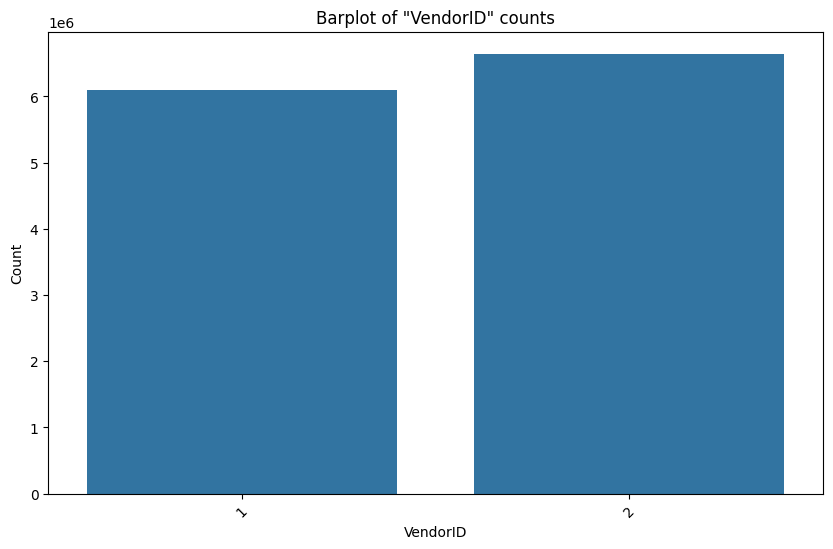

In [14]:
plot_cat_distribution(data=df, column_name="VendorID")

Построим круговую диаграмму распеределения значений VendorID (Код, указывающий на поставщика услуг TPEP, который предоставил запись)

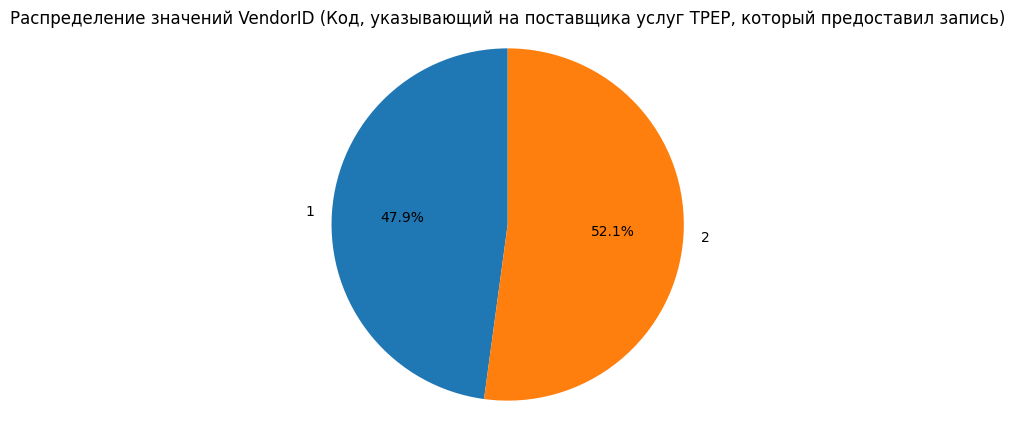

In [15]:
import matplotlib.pyplot as plt

# Подсчитываем количество True и False
count_df = df.groupBy("VendorID").count().toPandas()

# Построение круговой диаграммы
plt.figure(figsize=(5, 5))
plt.pie(count_df['count'], labels=count_df['VendorID'], autopct='%1.1f%%', startangle=90)
plt.axis('equal')  # Для равных осей, чтобы сделать круг
plt.title('Распределение значений VendorID (Код, указывающий на поставщика услуг TPEP, который предоставил запись)')
plt.show()

#### Анализ столбца 'passenger_count'

Посмотрим внимательно на значения в столбце. Видно, что в данном столбце расположен **дискретный количественный признак**.

In [16]:
unique_count = df.select("passenger_count").distinct().count()
print("Количество уникальных значений в столбце 'passenger_count':", unique_count)

null_count = df.filter(df.passenger_count.isNull()).count()
print("Количество пропущенных значений в столбце 'passenger_count':", null_count)

df.select("passenger_count").distinct().show()

Количество уникальных значений в столбце 'passenger_count': 10
Количество пропущенных значений в столбце 'passenger_count': 0


+---------------+
|passenger_count|
+---------------+
|              1|
|              6|
|              3|
|              5|
|              4|
|              8|
|              7|
|              2|
|              0|
|              9|
+---------------+



Построим круговую диаграмму распеределения значений passenger_count (количество пассажиров)

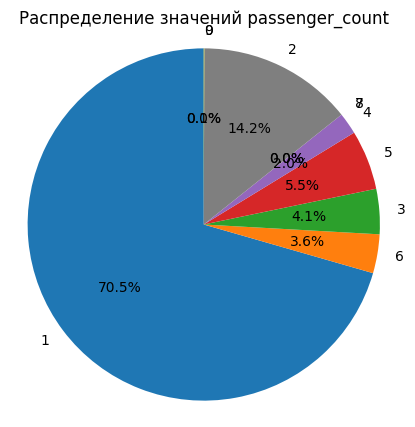

In [17]:
# Подсчитываем количество True и False
count_df = df.groupBy("passenger_count").count().toPandas()

# Построение круговой диаграммы
plt.figure(figsize=(5, 5))
plt.pie(count_df['count'], labels=count_df['passenger_count'], autopct='%1.1f%%', startangle=90)
plt.axis('equal')  # Для равных осей, чтобы сделать круг
plt.title('Распределение значений passenger_count')
plt.show()

Количество категорий признака passenger_count: 10


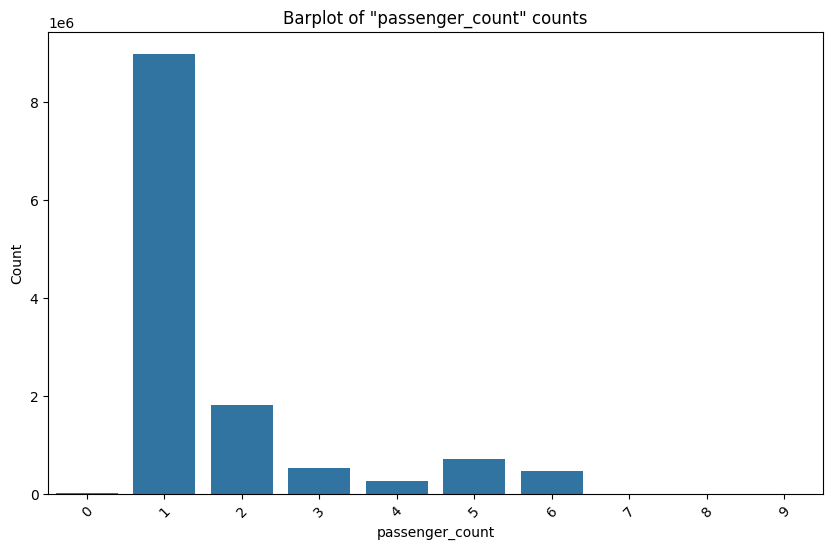

In [18]:
plot_cat_distribution(data=df, column_name="passenger_count")

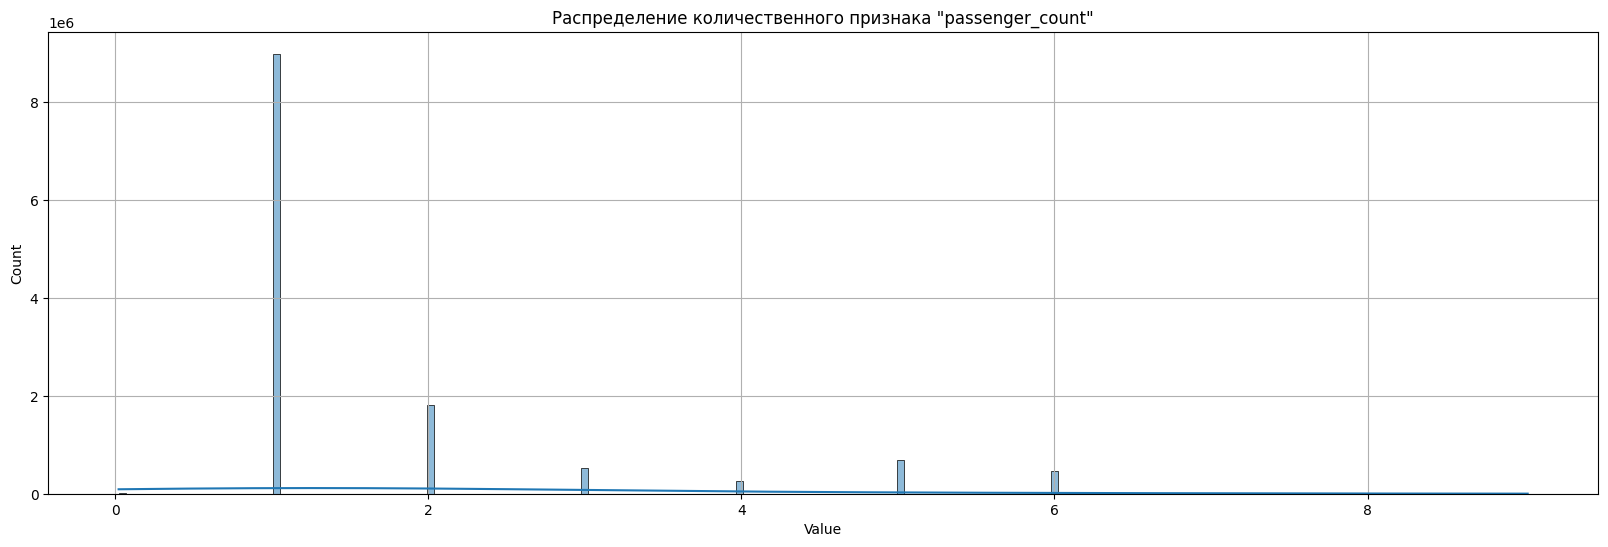

In [19]:
plot_quant_distribution(data=df, column="passenger_count")

Минимальное значение:          0.00
Среднее значение:              1.68
Среднеквадратичное отклонение: 1.34
Первый квартиль:               1.00
Медиана:                       1.00
Третий квартиль:               2.00
Максимальное значение:         9.00


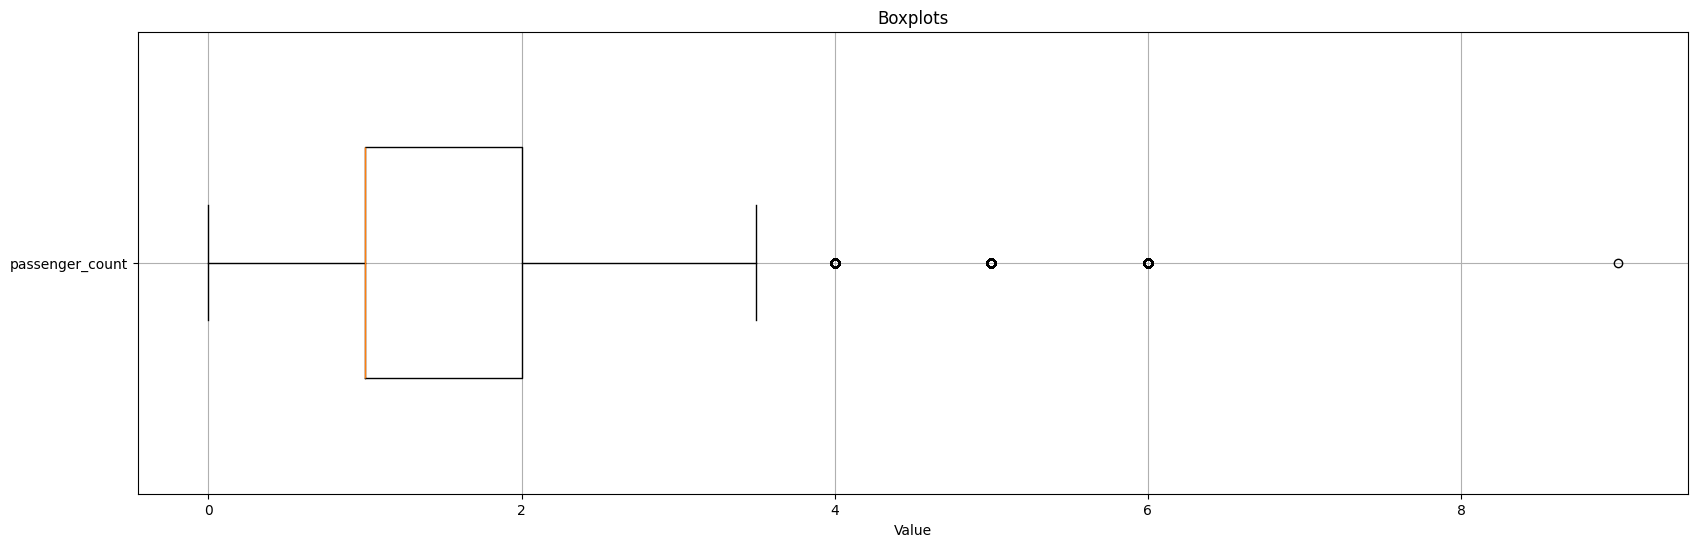

In [20]:
plot_boxplots(data=df, columns=["passenger_count"])

#### Анализ столбца 'trip_distance'
Данный признак - **количественный**

In [21]:
count_nulls(data=df, column_name="trip_distance")

Число колонок с NULL: 0 (0.00%)


In [22]:
#Отсортируем датафрейм по столбцу "trip_distance" и ограничим значения пределами от 0 до 100 миль
df.orderBy("trip_distance", ascending=False).where("trip_distance > 0").show()

+--------+---------------+-------------+----------+------------------+------------+-----------+-----+----------+------------+------------+
|VendorID|passenger_count|trip_distance|RateCodeID|store_and_fwd_flag|payment_type|fare_amount|extra|tip_amount|tolls_amount|total_amount|
+--------+---------------+-------------+----------+------------------+------------+-----------+-----+----------+------------+------------+
|       1|              1|  1.5420004E7|         1|             false|           2|       34.5|  0.5|       0.0|         0.0|        35.8|
|       1|              2|    1.23318E7|         1|              true|           2|        2.5|  0.0|       0.0|         0.0|         3.3|
|       1|              1|        1.2E7|         1|             false|           2|        4.5|  0.0|       0.0|         0.0|         5.3|
|       1|              1|  1.1800002E7|         1|             false|           2|        2.5|  1.0|       0.0|         0.0|         4.3|
|       1|              1| 

In [23]:
df = df.orderBy("trip_distance").where("trip_distance <= 100")
df.show()

+--------+---------------+-------------+----------+------------------+------------+-----------+-----+----------+------------+------------+
|VendorID|passenger_count|trip_distance|RateCodeID|store_and_fwd_flag|payment_type|fare_amount|extra|tip_amount|tolls_amount|total_amount|
+--------+---------------+-------------+----------+------------------+------------+-----------+-----+----------+------------+------------+
|       2|              1|          0.0|         5|             false|           1|       40.0|  0.0|      12.0|         0.0|        52.8|
|       2|              3|          0.0|         1|             false|           2|        2.5|  0.5|       0.0|         0.0|         3.8|
|       1|              1|          0.0|         1|             false|           3|        2.5|  0.0|       0.0|         0.0|         3.3|
|       1|              1|          0.0|         1|             false|           2|        5.0|  0.5|       0.0|         0.0|         6.3|
|       2|              1| 

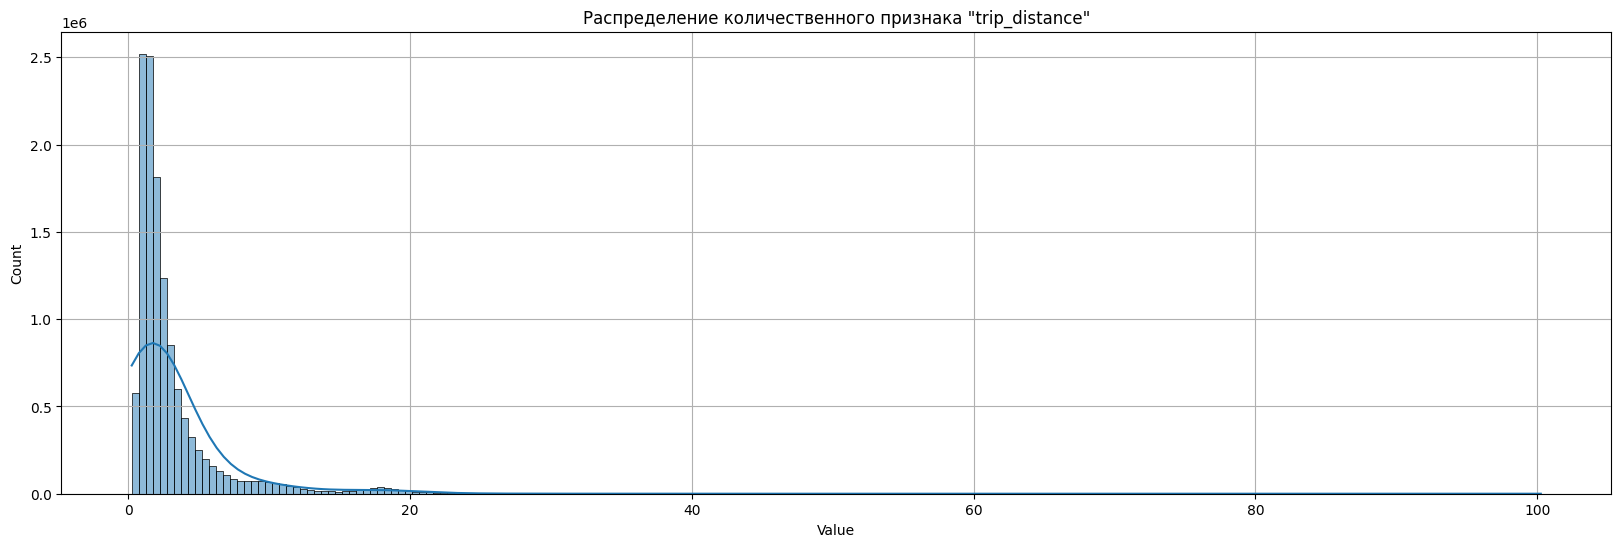

In [24]:
plot_quant_distribution(data=df, column="trip_distance")

#### Анализ столбца 'RateCodeID'
Посмотрим внимательно на значения в столбце. Видно, что в данном столбце расположен **категориальный признак**.

In [25]:
count_nulls(data=df, column_name="RateCodeID")

Число колонок с NULL: 0 (0.00%)


Удалим строки со странным значением RateCodeID = 99

RateCodeID может быть только целыми числами от 1 до 6

In [26]:
df = df.orderBy("RateCodeID").where("RateCodeID <= 7")

In [27]:
# Посчитаем количество пассажиров которые выбирали тот или иной тариф поездки в датафрейме.
(
    df
    .groupBy("RateCodeID")
    .count()
    .where("count > 0")
    .orderBy("count", ascending=False)
    .show()
)

+----------+--------+
|RateCodeID|   count|
+----------+--------+
|         1|12464778|
|         2|  224705|
|         5|   36866|
|         3|   17700|
|         4|    4125|
|         6|     134|
+----------+--------+



Количество категорий признака RateCodeID: 6


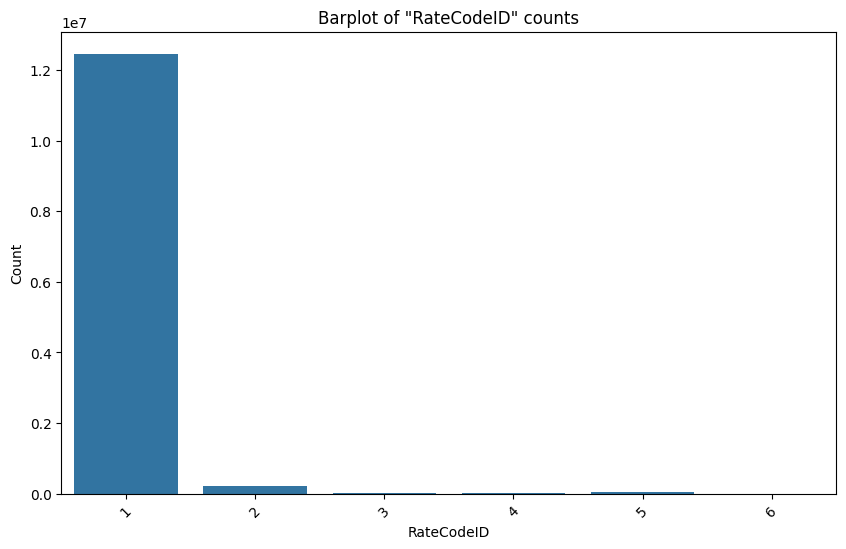

In [28]:
plot_cat_distribution(data=df, column_name="RateCodeID")

#### Анализ столбца `store_and_fwd_flag`

In [29]:
count_nulls(data=df, column_name="store_and_fwd_flag")

Число колонок с NULL: 0 (0.00%)


In [30]:
(
    df
    .groupBy("store_and_fwd_flag")
    .count()
    .where("count > 1")
    .orderBy("count", ascending=False)
    .show(50)
)

+------------------+--------+
|store_and_fwd_flag|   count|
+------------------+--------+
|             false|12633619|
|              true|  114689|
+------------------+--------+



#### Анализ столбца `payment_type`
Посмотрим внимательно на значения в столбце. Видно, что в данном столбце расположен **категориальный признак**.

In [31]:
count_nulls(data=df, column_name="payment_type")

Число колонок с NULL: 0 (0.00%)


Количество категорий признака payment_type: 5


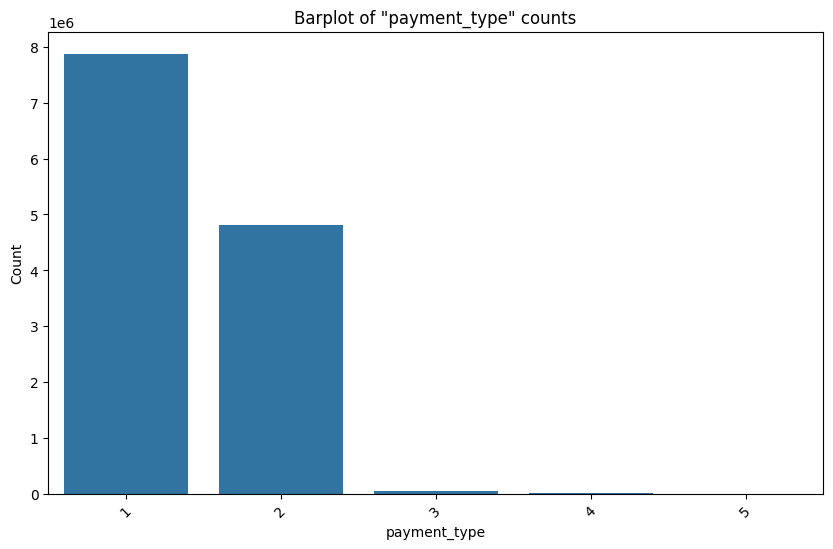

In [32]:
plot_cat_distribution(data=df, column_name="payment_type")

#### Анализ столбца `fare_amount`
Данный признак - **количественный**

In [33]:
count_nulls(data=df, column_name="fare_amount")

Число колонок с NULL: 0 (0.00%)


In [34]:
#Отсортируем датафрейм по столбцу "fare_amount"
df.orderBy("fare_amount", ascending=False).show()

+--------+---------------+-------------+----------+------------------+------------+-----------+------+----------+------------+------------+
|VendorID|passenger_count|trip_distance|RateCodeID|store_and_fwd_flag|payment_type|fare_amount| extra|tip_amount|tolls_amount|total_amount|
+--------+---------------+-------------+----------+------------------+------------+-----------+------+----------+------------+------------+
|       1|              1|          1.7|         1|             false|           2|     4008.0|   0.5|       0.0|         0.0|      4009.3|
|       2|              1|          0.4|         1|             false|           2|     3005.5|  0.05|       0.0|         0.0|     3006.35|
|       2|              1|          0.0|         5|             false|           1|     999.99| 100.0|       0.0|         0.0|     1099.99|
|       2|              1|          0.0|         5|             false|           1|     999.99|445.87|       0.0|         0.0|     1445.86|
|       2|          

Удалим отрицательные значения и выбросы

In [35]:
df = df.orderBy("fare_amount").where("fare_amount > 0")

In [36]:
df = df.orderBy("fare_amount").where("fare_amount < 100")

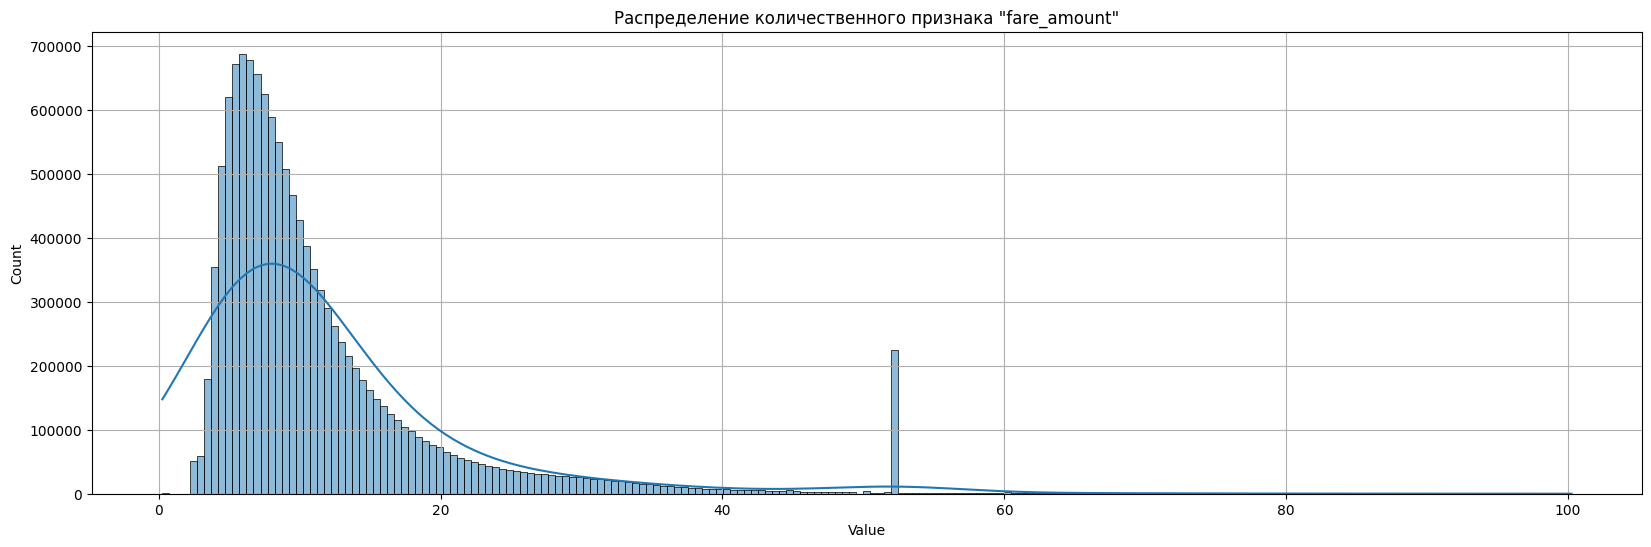

In [37]:
plot_quant_distribution(data=df, column="fare_amount")

Минимальное значение:          0.01
Среднее значение:              11.85
Среднеквадратичное отклонение: 9.53
Первый квартиль:               6.50
Медиана:                       9.00
Третий квартиль:               13.50
Максимальное значение:         99.99


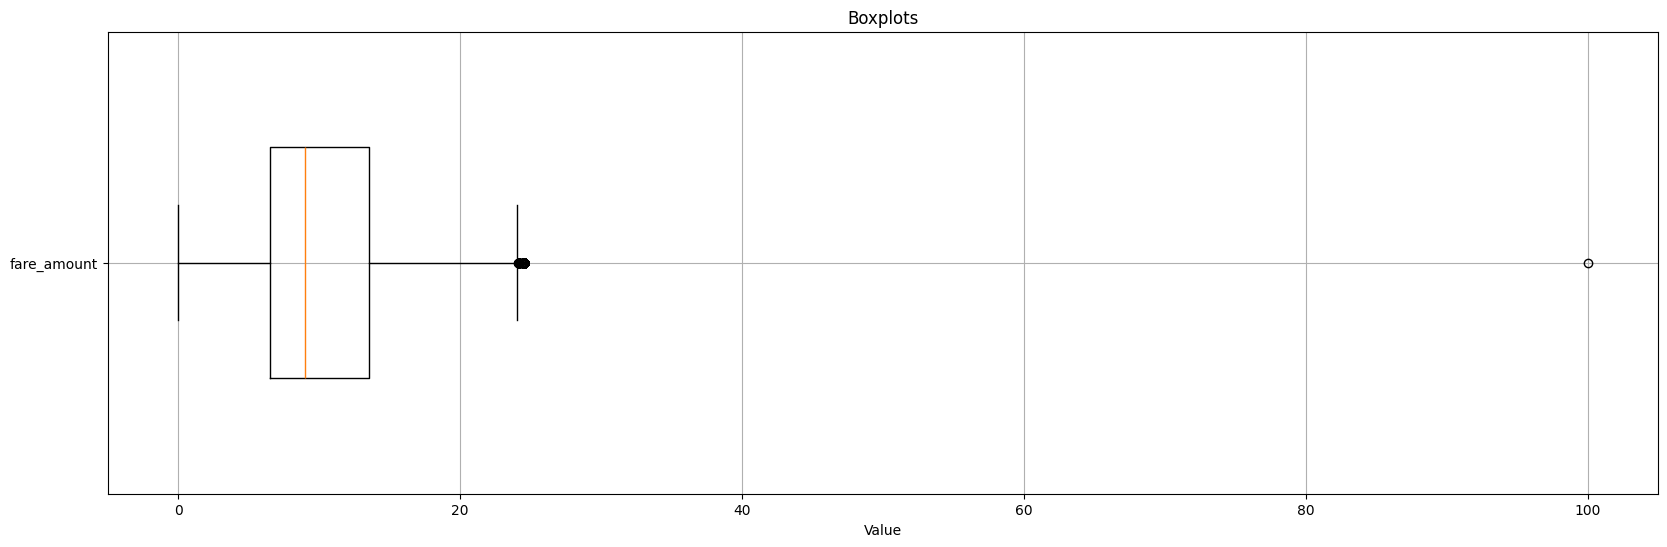

In [38]:
plot_boxplots(data=df, columns=["fare_amount"])

#### Анализ столбца `extra`
Данный признак - **количественный**

In [39]:
count_nulls(data=df, column_name="extra")

Число колонок с NULL: 0 (0.00%)


In [40]:
#Отсортируем датафрейм по столбцу "extra"
df.orderBy("extra", ascending=False).where("extra < 0").show()

+--------+---------------+-------------+----------+------------------+------------+-----------+------+----------+------------+------------+
|VendorID|passenger_count|trip_distance|RateCodeID|store_and_fwd_flag|payment_type|fare_amount| extra|tip_amount|tolls_amount|total_amount|
+--------+---------------+-------------+----------+------------------+------------+-----------+------+----------+------------+------------+
|       1|              1|          0.0|         1|             false|           2|        8.5| -0.09|       0.0|         0.0|        9.21|
|       1|              1|          2.6|         1|             false|           2|       12.5|  -0.4|       0.0|         0.0|        12.9|
|       1|              2|          0.0|         1|             false|           2|        6.5|  -2.0|       0.0|         0.0|         5.3|
|       1|              1|          0.0|         1|             false|           2|        8.0| -20.0|       0.0|         0.0|       -11.2|
|       1|          

Удалим отрицательные значения и выбросы

In [41]:
df = df.orderBy("extra").where("extra > 0")

In [42]:
df = df.orderBy("extra").where("extra < 10")

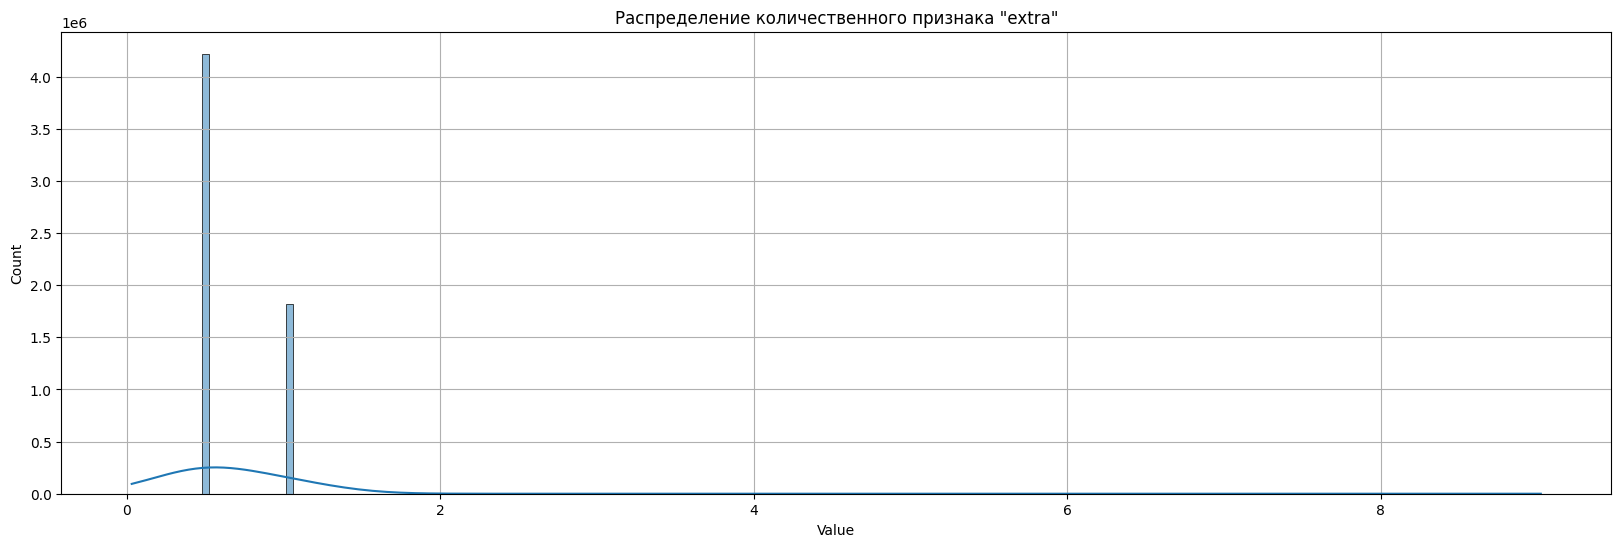

In [43]:
plot_quant_distribution(data=df, column="extra")

#### Анализ столбца `tip_amount`
Данный признак - **количественный**

In [44]:
count_nulls(data=df, column_name="tip_amount")

Число колонок с NULL: 0 (0.00%)


In [45]:
#Отсортируем датафрейм по столбцу "tip_amount"
df.orderBy("tip_amount", ascending=False).show()

+--------+---------------+-------------+----------+------------------+------------+-----------+-----+----------+------------+------------+
|VendorID|passenger_count|trip_distance|RateCodeID|store_and_fwd_flag|payment_type|fare_amount|extra|tip_amount|tolls_amount|total_amount|
+--------+---------------+-------------+----------+------------------+------------+-----------+-----+----------+------------+------------+
|       1|              2|          1.9|         1|             false|           1|        8.0|  0.5|     888.2|         0.0|       897.5|
|       1|              1|          1.4|         1|             false|           1|        7.5|  0.5|    606.57|         0.0|      615.37|
|       2|              1|          0.0|         1|             false|           1|        2.5|  0.5|     495.0|         0.0|       498.8|
|       2|              6|          0.0|         1|             false|           1|        2.5|  0.5|     440.0|         0.0|       443.8|
|       1|              1| 

Ограничим чаевые 100 долларами

In [46]:
df = df.orderBy("tip_amount").where("tip_amount < 100")


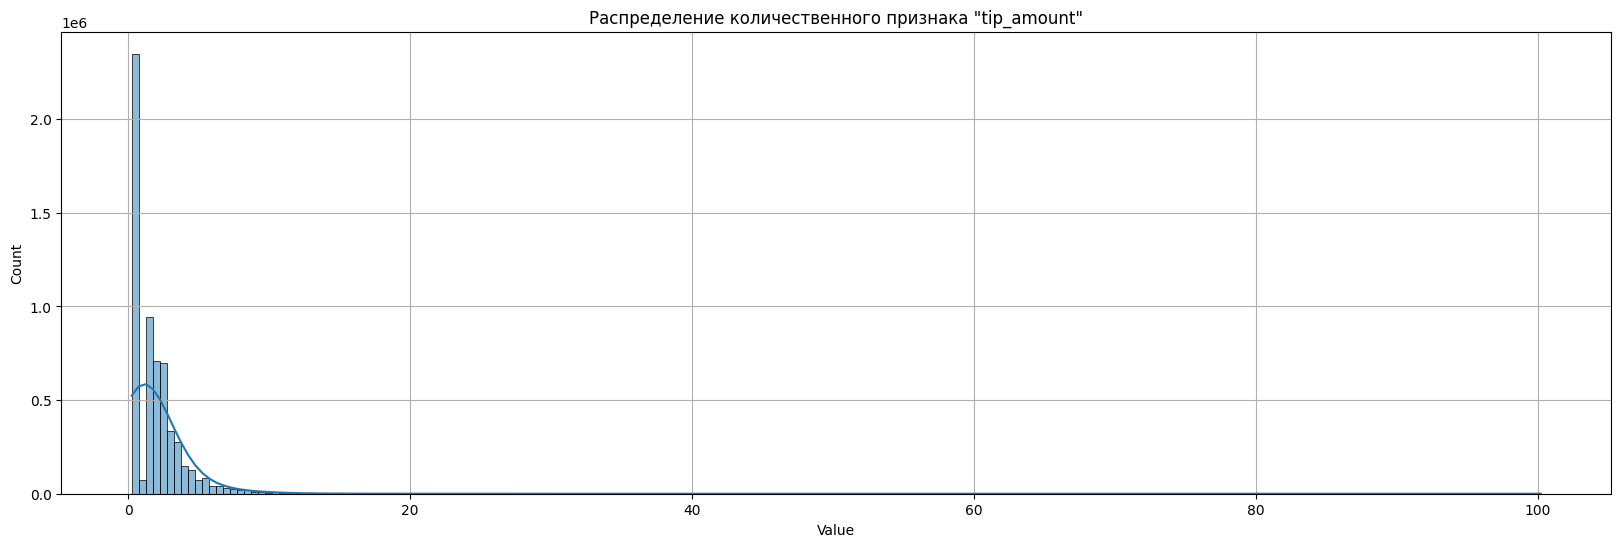

In [47]:
plot_quant_distribution(data=df, column="tip_amount")

#### Анализ столбца `tolls_amount`
Данный признак - **количественный**

In [48]:
count_nulls(data=df, column_name="tolls_amount")

Число колонок с NULL: 0 (0.00%)


In [49]:
#Отсортируем датафрейм по столбцу "tolls_amount"
df.orderBy("tolls_amount", ascending=False).show()

+--------+---------------+-------------+----------+------------------+------------+-----------+-----+----------+------------+------------+
|VendorID|passenger_count|trip_distance|RateCodeID|store_and_fwd_flag|payment_type|fare_amount|extra|tip_amount|tolls_amount|total_amount|
+--------+---------------+-------------+----------+------------------+------------+-----------+-----+----------+------------+------------+
|       1|              1|         10.8|         1|             false|           2|       32.5|  0.5|       0.0|     1000.66|     1034.46|
|       1|              2|          7.6|         1|             false|           4|       22.5|  0.5|       0.0|       750.0|       773.8|
|       1|              1|          9.9|         1|             false|           3|       30.0|  1.0|       0.0|      305.41|      337.21|
|       1|              1|          2.0|         1|             false|           2|        2.5|  0.5|       0.0|      205.31|      209.11|
|       1|              1| 

Ограничим tolls_amount 50 далларами

In [50]:
df = df.orderBy("tolls_amount").where("tolls_amount < 50")

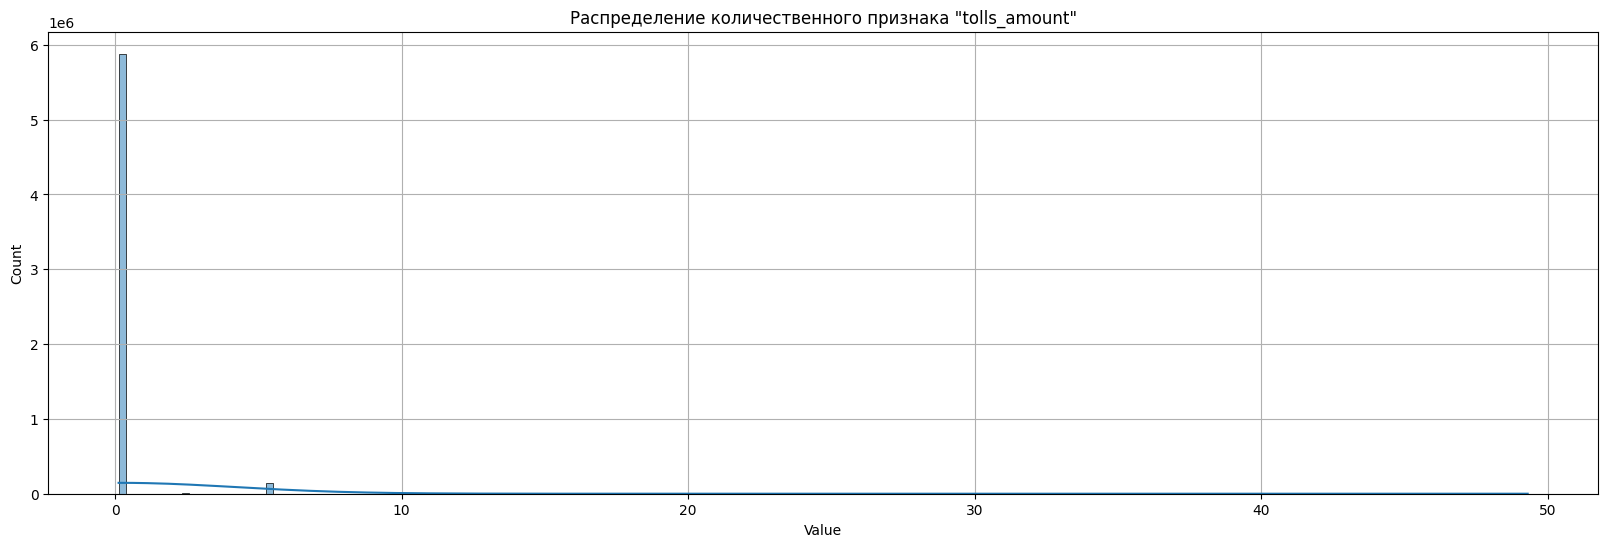

In [51]:
plot_quant_distribution(data=df, column="tolls_amount")

#### Анализ столбца `total_amount`
Данный признак - **количественный**

In [52]:
count_nulls(data=df, column_name="total_amount")

Число колонок с NULL: 0 (0.00%)


In [53]:
#Отсортируем датафрейм по столбцу "total_amount"
df.orderBy("total_amount", ascending=False).show()

+--------+---------------+-------------+----------+------------------+------------+-----------+-----+----------+------------+------------+
|VendorID|passenger_count|trip_distance|RateCodeID|store_and_fwd_flag|payment_type|fare_amount|extra|tip_amount|tolls_amount|total_amount|
+--------+---------------+-------------+----------+------------------+------------+-----------+-----+----------+------------+------------+
|       2|              1|        31.66|         1|             false|           1|       82.0|  0.5|      98.0|        5.33|      186.63|
|       1|              1|         18.6|         4|             false|           1|       84.0|  0.5|      95.0|         0.0|       180.3|
|       1|              1|         34.8|         1|             false|           1|       97.5|  0.5|     33.55|       35.49|      167.84|
|       2|              1|        34.32|         1|             false|           1|       89.0|  0.5|      71.0|        5.33|      166.63|
|       1|              2| 

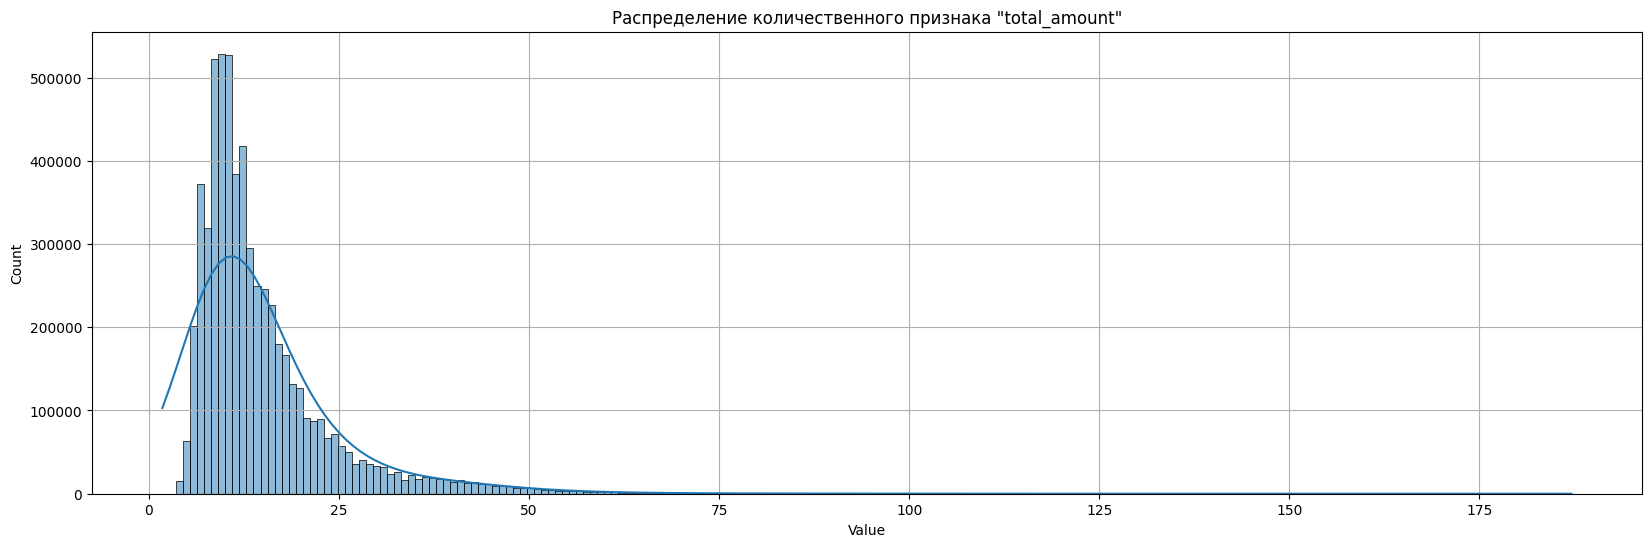

In [54]:
plot_quant_distribution(data=df, column="total_amount")

#### Расчет корреляции между количественными признаками

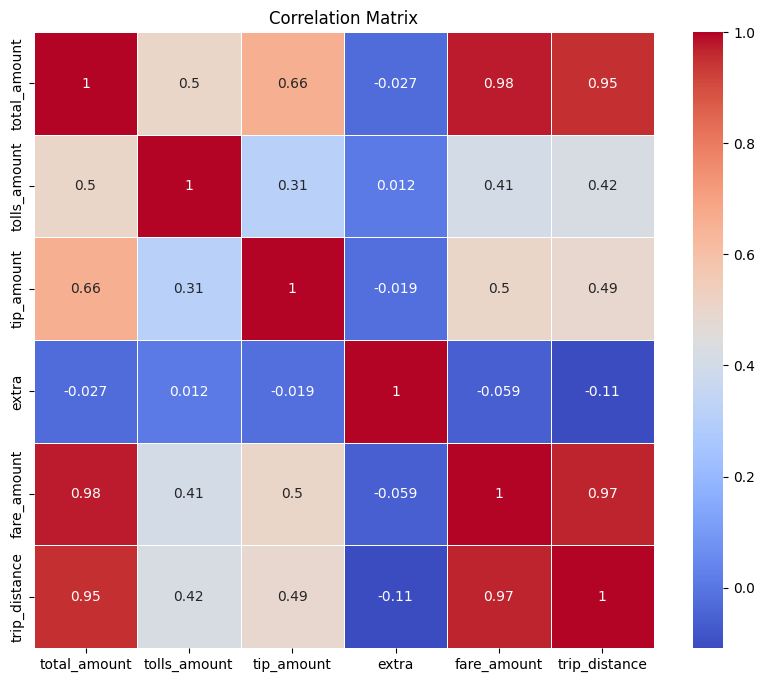

In [55]:
compute_and_visualize_correlation_matrix(
    data=df, columns=[
        "total_amount", "tolls_amount", "tip_amount", "extra", "fare_amount", "trip_distance"
    ]
)

Посмотрим, сколько объектов осталось после преобразований датасета.

In [56]:
df.count()

6036111

In [57]:
df.printSchema()

root
 |-- VendorID: integer (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_distance: float (nullable = true)
 |-- RateCodeID: integer (nullable = true)
 |-- store_and_fwd_flag: boolean (nullable = true)
 |-- payment_type: integer (nullable = true)
 |-- fare_amount: float (nullable = true)
 |-- extra: float (nullable = true)
 |-- tip_amount: float (nullable = true)
 |-- tolls_amount: float (nullable = true)
 |-- total_amount: float (nullable = true)



Сохраняет очищенную и обработанную таблицу на диск.

In [59]:
# Сохранение DataFrame в виде таблицы
df.writeTo("sobd_lab1_processed_table").using("iceberg").create()

In [60]:
for table in spark.catalog.listTables():
    print(table.name)

sobd_lab1_processed_table
sobd_lab1_table_gysynin


Обратите внимание, что при необходимости созданные базу данных и таблицу можно удалить следующими командами.

In [ ]:
# spark.sql("DROP TABLE spark_catalog.gysynin_dmitry_database.sobd_lab1_processed_table")
# spark.sql("DROP DATABASE spark_catalog.gysynin_dmitry_database")

DataFrame[]

Останавливаем `Spark`-сессию.

In [61]:
spark.stop()